In [44]:
%matplotlib inline

import boutdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import xhermes
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *
from code_comparison.grid_interp import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


# Overview

### I tuned fast recycling and went to MFP 0.1 with separate limiters and conduction limitation

# Hermes IO

In [2]:
casestore = dict()

In [3]:
   
db = CaseDB()
toload = [
	dict(name="afnE_1e19", id = "d26b-c0.25_f0.48_1e19"),
	# dict(name="afnE_3e19", id = "d26c-c0.25_f0.48_3e19"),
	dict(name="afnE_2e19_fixnbc", id = "d34-d28a_neutbc_fixes"),
	# dict(name="afn_new_cond0.1", id = "d21a-cond_alpha_0.1")
]
casestore = {}
for case in toload:
	casestore[case["name"]] = db.load_case_2D(case["id"], use_squash = True, verbose = True, use_xhermes = False)

- Reading case d26b-c0.25_f0.48_1e19
-----------------------
- Looking for squash file
- Squash file found. squash date 12/05/2023, 14:40:59, dmp file date 10/20/2023, 15:27:39

- Reading case d34-d28a_neutbc_fixes
-----------------------
- Looking for squash file
- Squash file found. squash date 12/12/2023, 11:28:35, dmp file date 12/11/2023, 19:20:57



### Get dataset

In [10]:
ds = casestore["afnE_2e19_fixnbc"].ds.isel(t=-1)

### Way to get extra fields from grid
- Originally thought psi was missing

In [313]:
# path = r"C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3b2-fatter_newhypno.nc"

# with nc.Dataset(path) as d:
# 	print(d.variables.keys())
# 	psixy = d["psixy"][:]
 
# # psixy = np.expand_dims(psixy, axis = 2)
# ds["psixy"] = xr.DataArray(psixy, dims = ("x", "theta"), name = "psixy")

dict_keys(['nx', 'ny', 'y_boundary_guards', 'curvature_type', 'Bt_axis', 'psi_axis', 'psi_bdry', 'psi_axis_gfile', 'psi_bdry_gfile', 'Rxy', 'Rxy_xlow', 'Rxy_ylow', 'Zxy', 'Zxy_xlow', 'Zxy_ylow', 'psixy', 'psixy_xlow', 'psixy_ylow', 'dx', 'dx_xlow', 'dx_ylow', 'dy', 'dy_xlow', 'dy_ylow', 'poloidal_distance', 'poloidal_distance_xlow', 'poloidal_distance_ylow', 'Brxy', 'Brxy_xlow', 'Brxy_ylow', 'Bzxy', 'Bzxy_xlow', 'Bzxy_ylow', 'Bpxy', 'Bpxy_xlow', 'Bpxy_ylow', 'Btxy', 'Btxy_xlow', 'Btxy_ylow', 'Bxy', 'Bxy_xlow', 'Bxy_ylow', 'hy', 'hy_xlow', 'hy_ylow', 'dphidy', 'dphidy_xlow', 'dphidy_ylow', 'ShiftTorsion', 'ShiftTorsion_xlow', 'ShiftTorsion_ylow', 'zShift', 'zShift_xlow', 'zShift_ylow', 'g11', 'g11_xlow', 'g11_ylow', 'g22', 'g22_xlow', 'g22_ylow', 'g33', 'g33_xlow', 'g33_ylow', 'g12', 'g12_xlow', 'g12_ylow', 'g13', 'g13_xlow', 'g13_ylow', 'g23', 'g23_xlow', 'g23_ylow', 'J', 'J_xlow', 'J_ylow', 'g_11', 'g_11_xlow', 'g_11_ylow', 'g_22', 'g_22_xlow', 'g_22_ylow', 'g_33', 'g_33_xlow', 'g_33_

In [5]:
plt.close("all")
%matplotlib inline

# SOLPS io

In [5]:
solpscases = {
	"noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
	"tightwall_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19",
	"tightwall_noD2_1e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2",
	"tightwall_noD2_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2",
	"tightwall_noD2_3e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2",
	
}



In [6]:
casechoice = "tightwall_noD2_2e19"
spc = self = SOLPScase(solpscases[casechoice])
g = read_b2fgmtry(where = solpscases[casechoice], save = False, ghost_cells = True, force = True)


b2fgmtry loaded from .pkl
read_b2fgmtry -- file version 03.000.007
110 36


# Common functions

In [7]:
def group_selection(data, selections):
	"""
	Returns mask equivalent to selection of multiple regions
	The mask can be used as selector, i.e. data[mask]
	Inputs
	------
	data : np.ndarray
		Underlying data which provides structure to mask
	selections : list
		List of selectors (tuples) to group

	"""
	mask = np.zeros_like(data)
	for selection in selections:
		mask[selection] = 1
	mask = mask > 0
	return mask


## Region grouping for both codes
group_rules = dict(
	lower_inner_PFR = ["lower_inner_PFR"],
	inner_full_SOL = ["lower_inner_SOL", "inner_SOL", "upper_inner_SOL"],
	inner_core = ["inner_core"],
	upper_inner_PFR = ["upper_inner_PFR"],
	upper_outer_PFR = ["upper_outer_PFR"],
	outer_full_SOL = ["lower_outer_SOL", "outer_SOL", "upper_outer_SOL"],
	outer_core = ["outer_core"],
	lower_outer_PFR = ["lower_outer_PFR"]
)

# Field transplanter class

b2fgmtry loaded from .pkl
read_b2fgmtry -- file version 03.000.007
110 36
Psi aligned


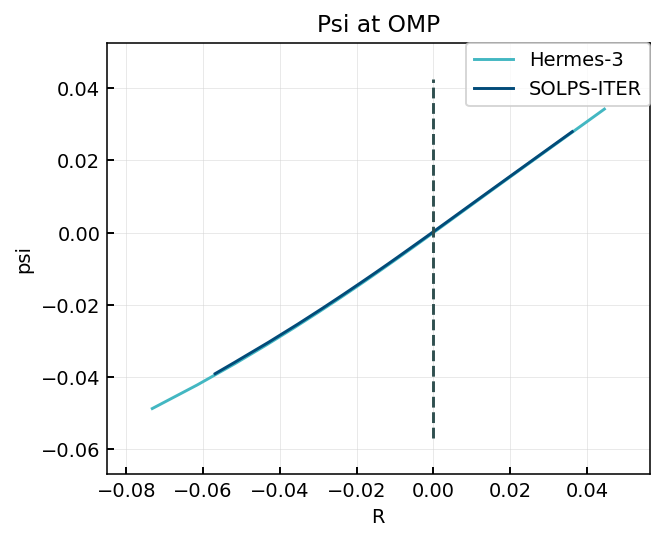

In [46]:
tp = TransplantFromSOLPS(hermes_ds = ds, solps_path = solpscases[casechoice])
tp.align_psi(diagnose = True)

# Hermes-3

## Flux grid

In [55]:
x = psixy
y = ds["theta_idx"].values
y = np.expand_dims(y, axis = 0)
y = np.expand_dims(y, axis = 2)
y = np.repeat(y, x.shape[0], axis = 0)

print(x.shape)
print(y.shape)

(40, 108, 1)
(40, 108, 1)


In [319]:
%matplotlib inline

[autoreload of code_comparison.grid_interp failed: Traceback (most recent call last):
  File "c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
  File "C:\Users\mikek\AppData\Local\Programs\Python\Python310\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "c:\Users\mikek\OneDrive\Project\python-packages\sdtools\

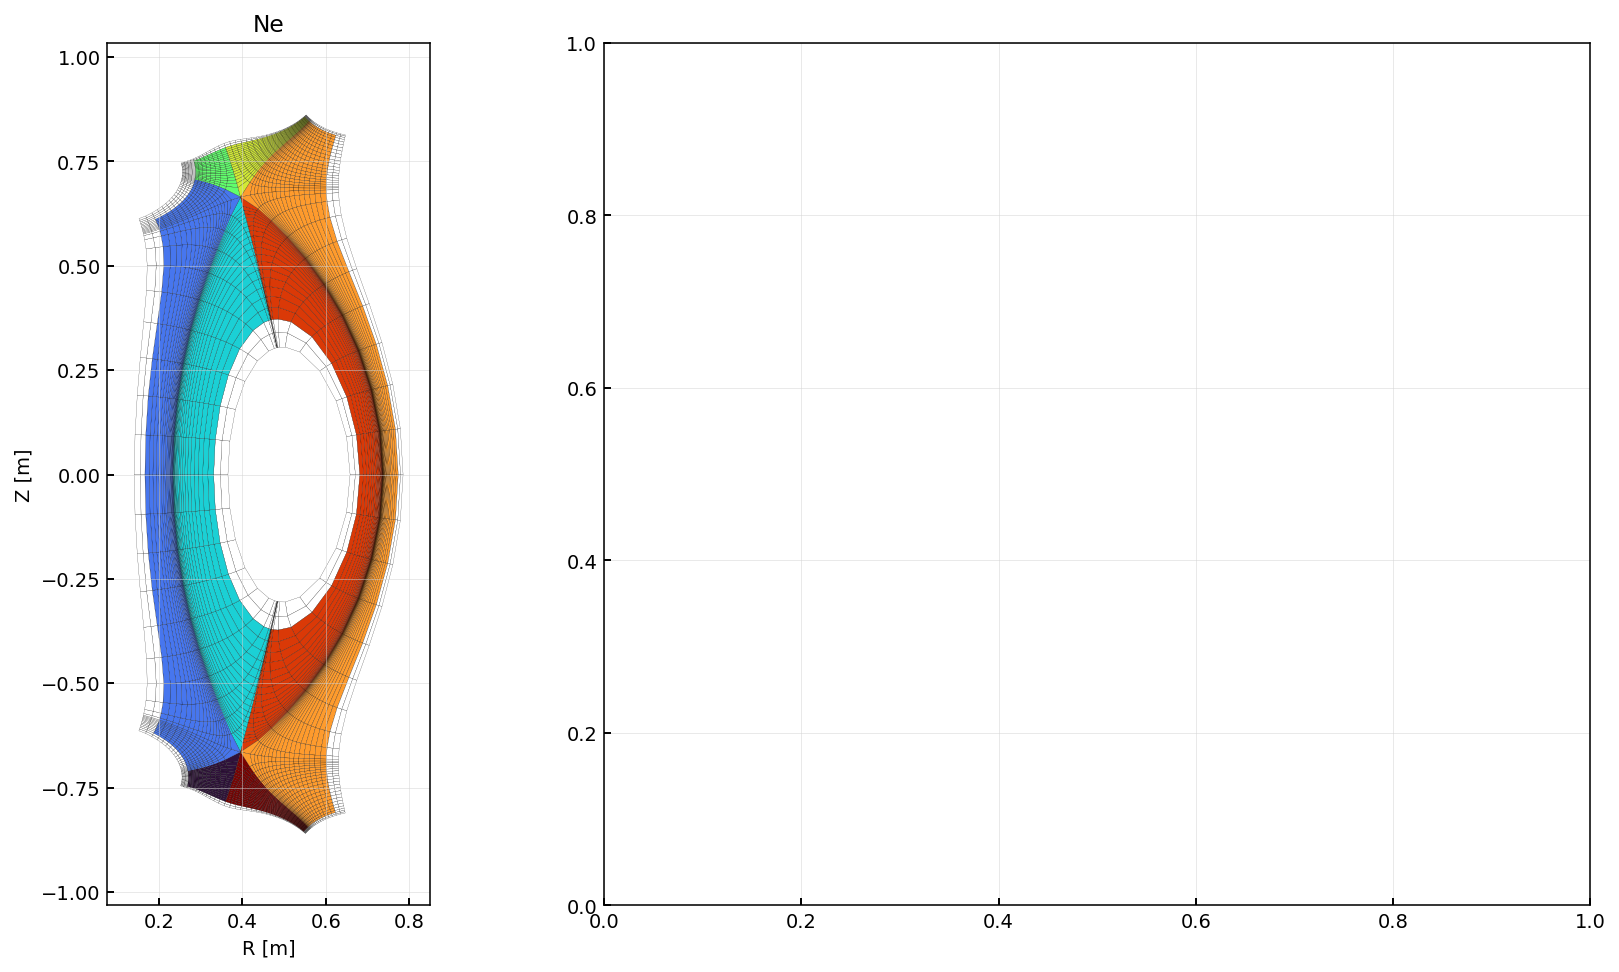

In [53]:
fig, axes = plt.subplots(1, 2, dpi=140, figsize=(14, 8), width_ratios=(0.4, 1))

tp.get_hermes_regions()
regions = tp.hgroup_sel
tp.plot_hermes_regions(ax=axes[0], regions=tp.hgroup_sel)

C:\Users\mikek\AppData\Local\Temp\ipykernel_26656\2450786312.py:50: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axes[1].pcolormesh(x_region, y_region, np.ones_like(x_region),


Text(0.5, 1.0, 'Flux space grid')

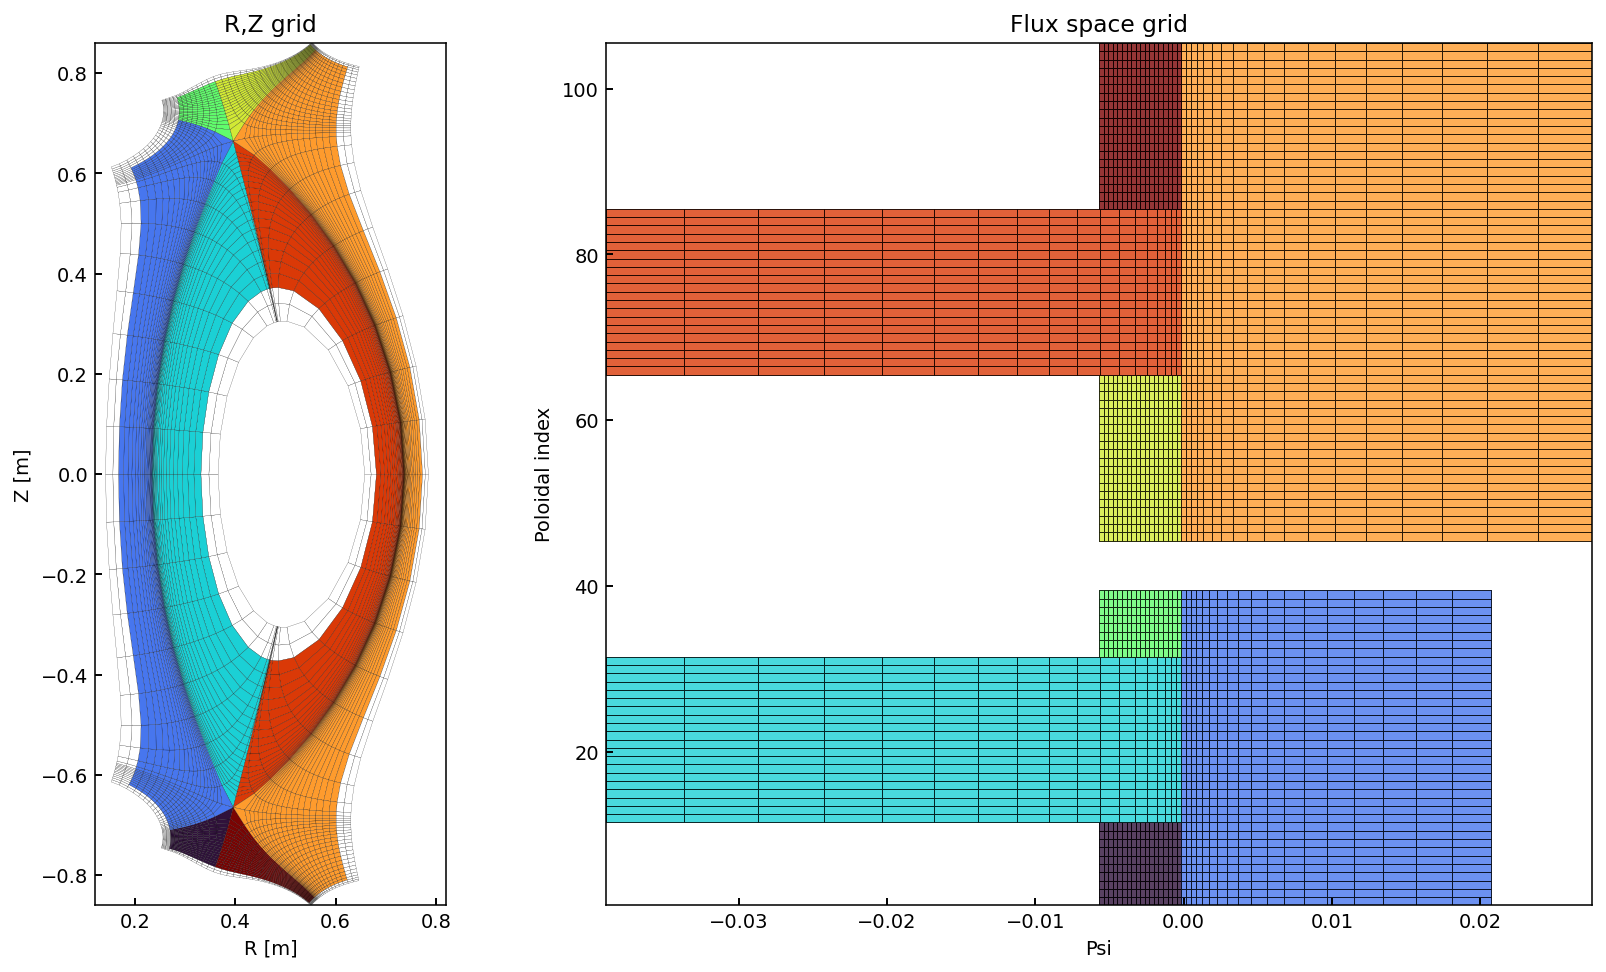

In [49]:
ds["psi_poloidal"] -= ds["psi_poloidal"].isel(x=ds.metadata["ixseps1"])

plt.close("all")
m = ds.metadata


colors = list(mpl.colormaps["turbo"](np.linspace(0, 1, len(regions.keys()))))
cmap = mpl.colors.ListedColormap(["white"] + colors)

fig, axes = plt.subplots(1, 2, dpi=140, figsize=(14, 8), width_ratios=(0.4, 1))
# x = np.cumsum(ds["dx"], axis = 0)

x = ds["psi_poloidal"].values
y = ds["theta_idx"].values
y = np.expand_dims(y, axis=0)
y = np.expand_dims(y, axis=2)
y = np.repeat(y, x.shape[0], axis=0)

x = x.squeeze()
y = y.squeeze()

data = ds["Ne"].copy()
data.loc[:] = 0

for i, key in enumerate(regions):
    i += 1
    # data.isel({"x" : regions[key][0], "theta" : regions[key][1]})[:] = i
    data.data[regions[key]] = i

# data = ds["Ne"].where(regions[region] is True)
data.bout.polygon(
    ax=axes[0],
    separatrix=False,
    targets=False,
    cmap=cmap,
    antialias=True,
    add_colorbar=False,
    linewidth=0.1,
    vmin=0,
    vmax=len(regions.keys()),
)

for i, region in enumerate(regions):

    slices = regions[region]
    x_region = x[slices]
    y_region = y[slices]

    axes[1].pcolormesh(
        x_region,
        y_region,
        np.ones_like(x_region),
        cmap=mpl.colors.ListedColormap(colors[i]),
        vmin=0,
        vmax=len(regions.keys()),
        rasterized=True,
        edgecolor="black",
        linewidth=0.5,
        alpha=0.8,
        shading="nearest",
    )

axes[0].autoscale()
axes[0].set_xlim(0.12, 0.82)
axes[0].set_ylim(-0.86, 0.86)
for ax in axes:
    ax.grid(visible=False)
axes[1].set_xlabel("Psi")
axes[1].set_ylabel("Poloidal index")
axes[0].set_title("R,Z grid")
axes[1].set_title("Flux space grid")

# SOLPS

## Get poloidal mesh

In [ ]:
ri = g["resignore"]
inds = np.where(ri == 0)

for i in inds[0]:
	print(f'{inds[0][i]}, {inds[1][i]}, {inds[2][i]}')

In [88]:
leftcut = g["leftcut"].astype(np.int64)
rightcut = g["rightcut"].astype(np.int64)
topcut = g["topcut"].astype(np.int64)
# sep = spc.g["sep"]
sep = topcut[1]
upper_break = spc.g["upper_break"].astype(np.int64)

for x in [leftcut, rightcut, topcut, sep, upper_break]:
	print(x)

[12 36]
[92 68]
[18 18]
18
50


## Flux grid

C:\Users\mikek\AppData\Local\Temp\ipykernel_26656\45557006.py:94: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axes[1].pcolormesh(region_x, region_y, np.ones((region_x.shape)),


Text(0, 0.5, 'Poloidal cell index')

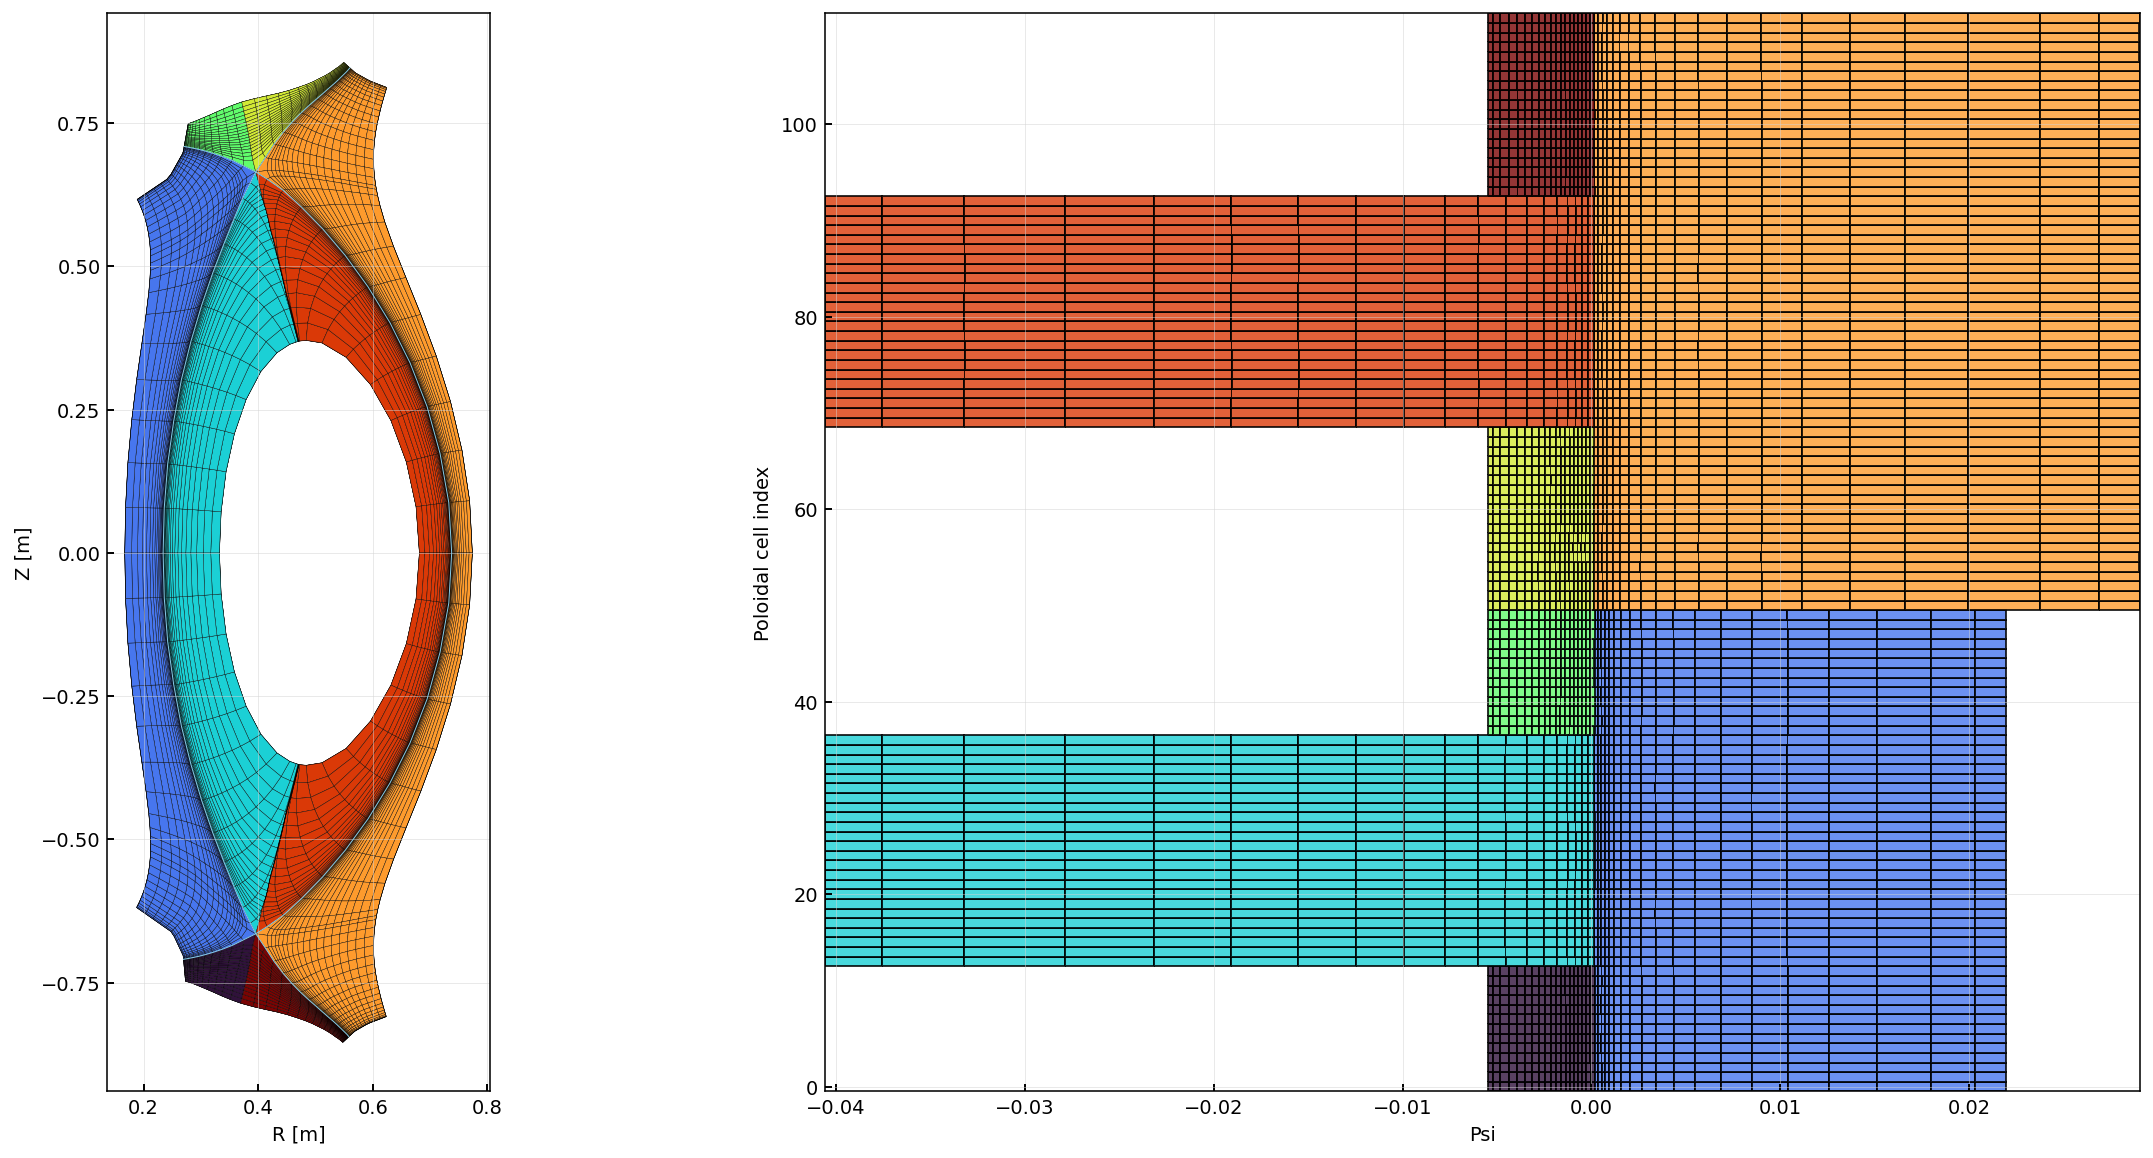

In [26]:
plt.close("all")

leftcut = g["leftcut"].astype(np.int64)
rightcut = g["rightcut"].astype(np.int64)
topcut = g["topcut"].astype(np.int64)
# sep = spc.g["sep"]
sep = topcut[1]
upper_break = spc.g["upper_break"].astype(np.int64)


### Original regions
f = 1  # Offset factor. Idk why it's required, and it seems to change between 1 and 2
region_sel = {}
region_sel["lower_inner_PFR"] = (slice(None, leftcut[0]+1), slice(None, sep+1))
region_sel["lower_inner_SOL"] = (slice(None, leftcut[0]+1), slice(sep+1, None))
region_sel["inner_core"] = (slice(leftcut[0]+1, leftcut[1]+1), slice(None, sep+1))
region_sel["inner_SOL"] = (slice(leftcut[0]+1, leftcut[1]+1), slice(sep+1, None))
region_sel["upper_inner_PFR"] = (slice(leftcut[1]+1, upper_break), slice(None, sep+1))
region_sel["upper_inner_SOL"] = (slice(leftcut[1]+1, upper_break), slice(sep+1, None))
region_sel["upper_outer_PFR"] = (slice(upper_break, rightcut[1]+1), slice(None, sep+1))
region_sel["upper_outer_SOL"] = (slice(upper_break, rightcut[1]+1), slice(sep+1, None))
region_sel["outer_core"] = (slice(rightcut[1]+1, rightcut[0]+1), slice(None, sep+1))
region_sel["outer_SOL"] = (slice(rightcut[1]+1, rightcut[0]+1), slice(sep+1, None))
region_sel["lower_outer_PFR"] = (slice(rightcut[0]+1, None), slice(None, sep+1))
region_sel["lower_outer_SOL"] = (slice(rightcut[0]+1, None), slice(sep+1, None))


data = spc.bal["ne"][:]
data = np.zeros_like(data)


### Grouped regions
group_sel = {}
group_sel["lower_inner_PFR"] = region_sel["lower_inner_PFR"]
group_sel["inner_full_SOL"] = (slice(None, upper_break), slice(sep+1, None))
group_sel["inner_core"] = region_sel["inner_core"]
group_sel["upper_inner_PFR"] = region_sel["upper_inner_PFR"]
group_sel["upper_outer_PFR"] = region_sel["upper_outer_PFR"]
group_sel["outer_full_SOL"] = (slice(upper_break, None), slice(sep+1, None))
group_sel["outer_core"] = region_sel["outer_core"]
group_sel["lower_outer_PFR"] = region_sel["lower_outer_PFR"]
		
regions = group_sel


data = spc.bal["ne"][:]
data = np.zeros_like(data)

# data[region_sel["lower_inner_pfr"]] = 1
# data[region_sel["lower_inner_SOL"]] = 2

for i, key in enumerate(regions):
	i += 1
	# if list(region_sel.keys())[-1] in key:
	#         data[region_sel[key]] = i
			
	data[regions[key]] = i

colors = mpl.colormaps["turbo"](np.linspace(0, 1, len(regions.keys())))
scale =  2
fig, axes = plt.subplots(1,2, dpi = 140, figsize = (10* scale,5* scale), width_ratios=(0.5,1))


spc.plot_2d("", ax = axes[0], data = data, cmap = mpl.colors.ListedColormap(["white"] + list(colors)),
	antialias = True, 
	cbar = False,
	vmin = 0, vmax = len(regions.keys())+1,
	linecolor = "black", linewidth = 0.2,
	separatrix_kwargs = dict(lw = 0.5, c = "skyblue"))
 
x = spsi

# get y
y = np.array(range(x.shape[0]))
y = np.expand_dims(y, axis = 1)
y = np.repeat(y, x.shape[1], axis = 1)

for i, key in enumerate(regions):
	# if list(regions.keys())[-1] in key:
	#         data[regions[key]] = i
	"""
	Remember that SOLPS nomenclature is opposite: X is poloidal, Y is radial
 
	# """
	# hx = np.cumsum(spc.g["hx"], axis = 0)         # POLOIDAL
	# hy = np.cumsum(spc.g["hy"], axis = 1)        # RADIAL 
 
	# x = hy[regions[key]]
	# y = hx[regions[key]]
 
	region_x = x[regions[key]]
	region_y = y[regions[key]]

	axes[1].pcolormesh(region_x, region_y, np.ones((region_x.shape)), 
				
				cmap = mpl.colors.ListedColormap([colors[i]]),
				rasterized = True,
				edgecolor = "k",
				linewidth = 0.1,
				alpha = 0.8,
				shading = "nearest")
		
axes[1].set_xlabel("Psi")
axes[1].set_ylabel("Poloidal cell index")

# Hermes-3 and SOLPS on a region basis

## drad /dl basis
- This doesn't work because you need h_theta to reproduce dl (poloidal length)
- h_theta is kind of like an angle - it's something which unwraps the case poloidally
- The closest replacement for this is the cell index, but that's not so easy because you have to adjust it to map it from SOLPS to Hermes-3
- Keeping the below for refernce but it doesnt work


C:\Users\mikek\AppData\Local\Temp\ipykernel_52844\1221845868.py:49: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axes[0,0].pcolormesh(reg["R"], reg["Z"], c_h, **stylekwargs)
C:\Users\mikek\AppData\Local\Temp\ipykernel_52844\1221845868.py:53: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axes[0,1].pcolormesh(R_s, Z_s, c_s, **stylekwargs)


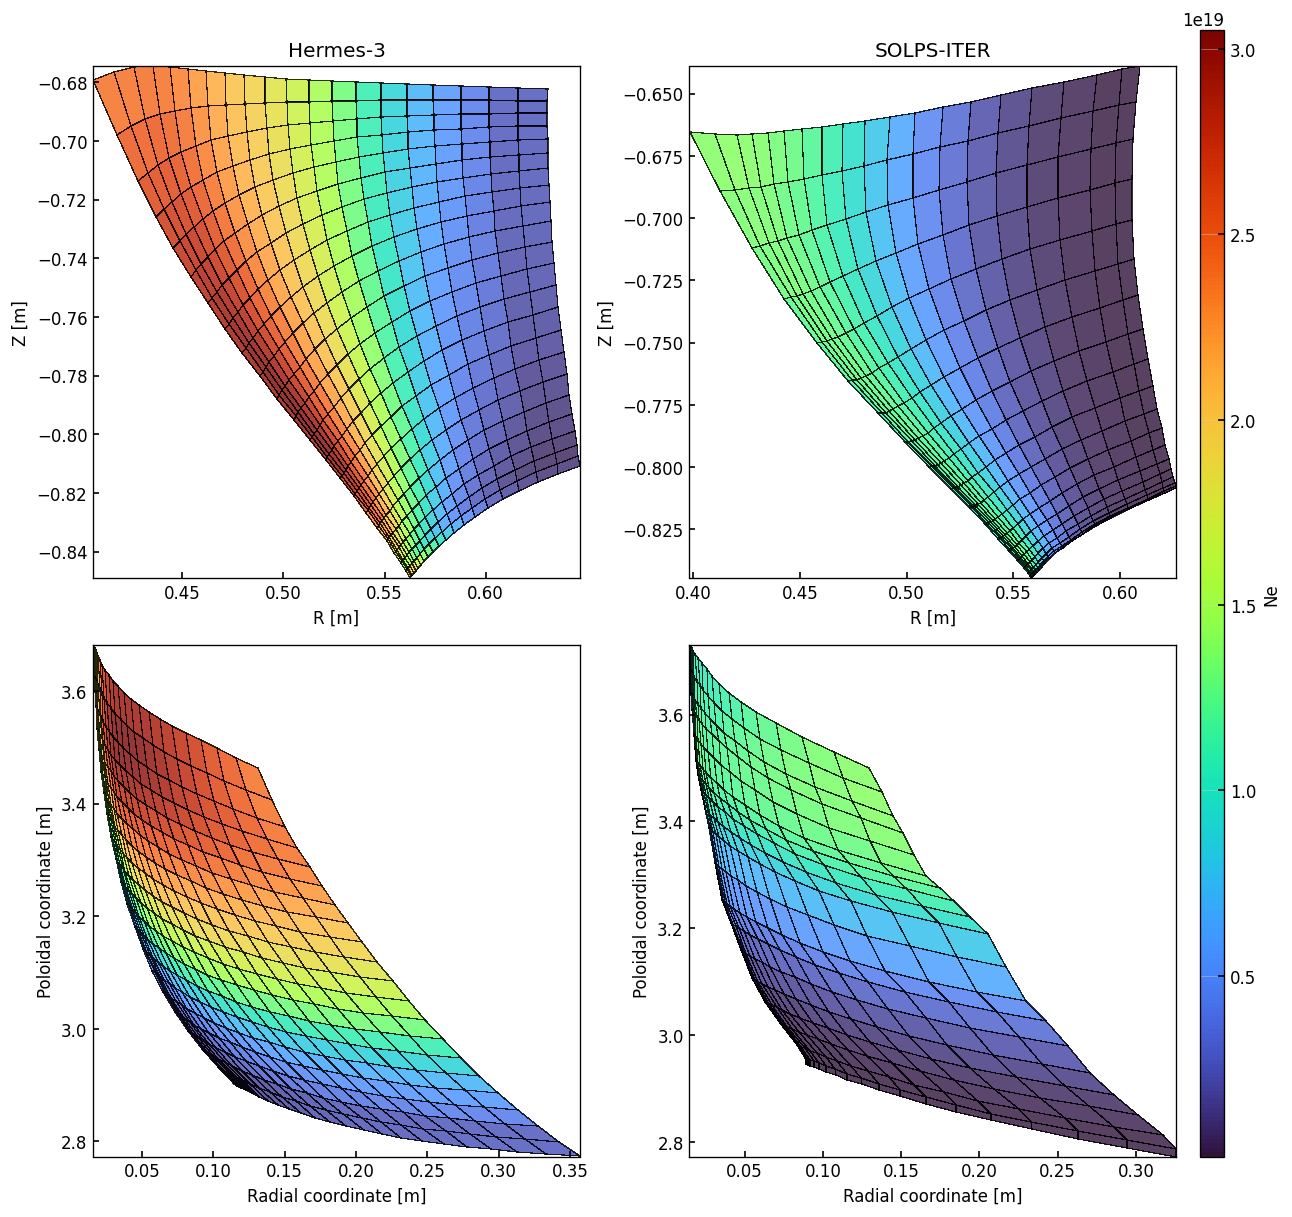

In [147]:
plt.close("all")

# region = "lower_inner_PFR"
# for region in regions:
for region in ["lower_outer_SOL"]:
	color = colors[list(regions).index(region)]
	cmap = mpl.colors.ListedColormap([color])
	cmap = "turbo"
	logscale = False


	## Data prep
	# Hermes-3
	reg = ds[ds.regions[region].get_slices()]
	# pol_h = np.cumsum(reg["dl"], axis = 1)
	# rad_h = np.cumsum(reg["dr"], axis = 0)
 
	pol_h = np.cumsum(ds["dl"], axis = 1)[ds.regions[region].get_slices()]
	rad_h = np.cumsum(ds["dr"], axis = 0)[ds.regions[region].get_slices()]
	c_h = reg["Ne"].values

	# SOLPS-ITER
	hx = np.cumsum(spc.g["hx"], axis = 0)         # POLOIDAL
	hy = np.cumsum(spc.g["hy"], axis = 1)        # RADIAL 
	pol_s = hx[region_sel[region]]
	rad_s = hy[region_sel[region]]
	R_s = spc.g["R"][region_sel[region]]
	Z_s = spc.g["Z"][region_sel[region]]
	c_s = spc.bal["ne"][:][region_sel[region]]

	## Plots
	fig, axes = plt.subplots(2,2, figsize = (10,10))

	vmin = np.min([np.min(c_h), np.min(c_s)])
	vmax = np.max([np.max(c_h), np.max(c_s)])
	norm = create_norm(logscale, None, vmin, vmax)
	
	stylekwargs = dict(cmap = cmap,
				rasterized = True,
				edgecolor = "k",
				linewidth = 0.1,
				alpha = 0.8,
				shading = "nearest",
				norm = norm
				)

	# Hermes-3
	axes[1,0].pcolormesh(rad_h, pol_h, c_h, **stylekwargs)
	axes[0,0].pcolormesh(reg["R"], reg["Z"], c_h, **stylekwargs)

	# SOLPS-ITER
	axes[1,1].pcolormesh(rad_s, pol_s, c_s, **stylekwargs)
	axes[0,1].pcolormesh(R_s, Z_s, c_s, **stylekwargs)

	## Formatting
	for ax in axes.flatten():
		ax.grid(False)
		
	for ax in axes[0,:].flatten():
		ax.set_xlabel("R [m]")
		ax.set_ylabel("Z [m]")
	
	for ax in axes[1,:].flatten():
		ax.set_xlabel("Radial coordinate [m]")
		ax.set_ylabel("Poloidal coordinate [m]")
	
	axes[0,0].set_title("Hermes-3")
	axes[0,1].set_title("SOLPS-ITER")

	sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
	fig.tight_layout()
	cax = fig.add_axes([
		axes[0,1].get_position().x1+0.02,
		axes[1,1].get_position().y0,
		0.02,
		axes[1,1].get_position().height * 2.2
	])

	cbar = plt.colorbar(mappable = sm, cax=cax, label = "Ne") # Similar to fig.colorbar(im, cax = cax)


## Using psi and poloidal index mapping
- Need to unwrap the grid to show it in a way that takes the field out and makes it rectangular
- Psi does that for the radial direction
- In the poloidal in BOUT++ we have h_theta, which is kind of like a poloidal angle but it cannot be calculated from first principles
- The closest replacement is the poloidal cell index
- We can do this on a per region basis and normalise the poloidal cell index from 0 to 1. Unfortunately this probably won't work very well unless the mapping is manually adjusted to account for non-orthogonal cells etc

In [94]:
g["hx"].shape

(110, 36)

In [91]:
g["fpsi"].shape

(110, 36, 4)

C:\Users\mikek\AppData\Local\Temp\ipykernel_26656\2087453217.py:71: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axes[1,0].pcolormesh(rad_h, pol_h, c_h, **stylekwargs)
C:\Users\mikek\AppData\Local\Temp\ipykernel_26656\2087453217.py:72: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axes[0,0].pcolormesh(R_h, Z_h, c_h, **stylekwargs)
C:\Users\mikek\AppData\Local\Temp\ipykernel_26656\2087453217.py:75: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, 

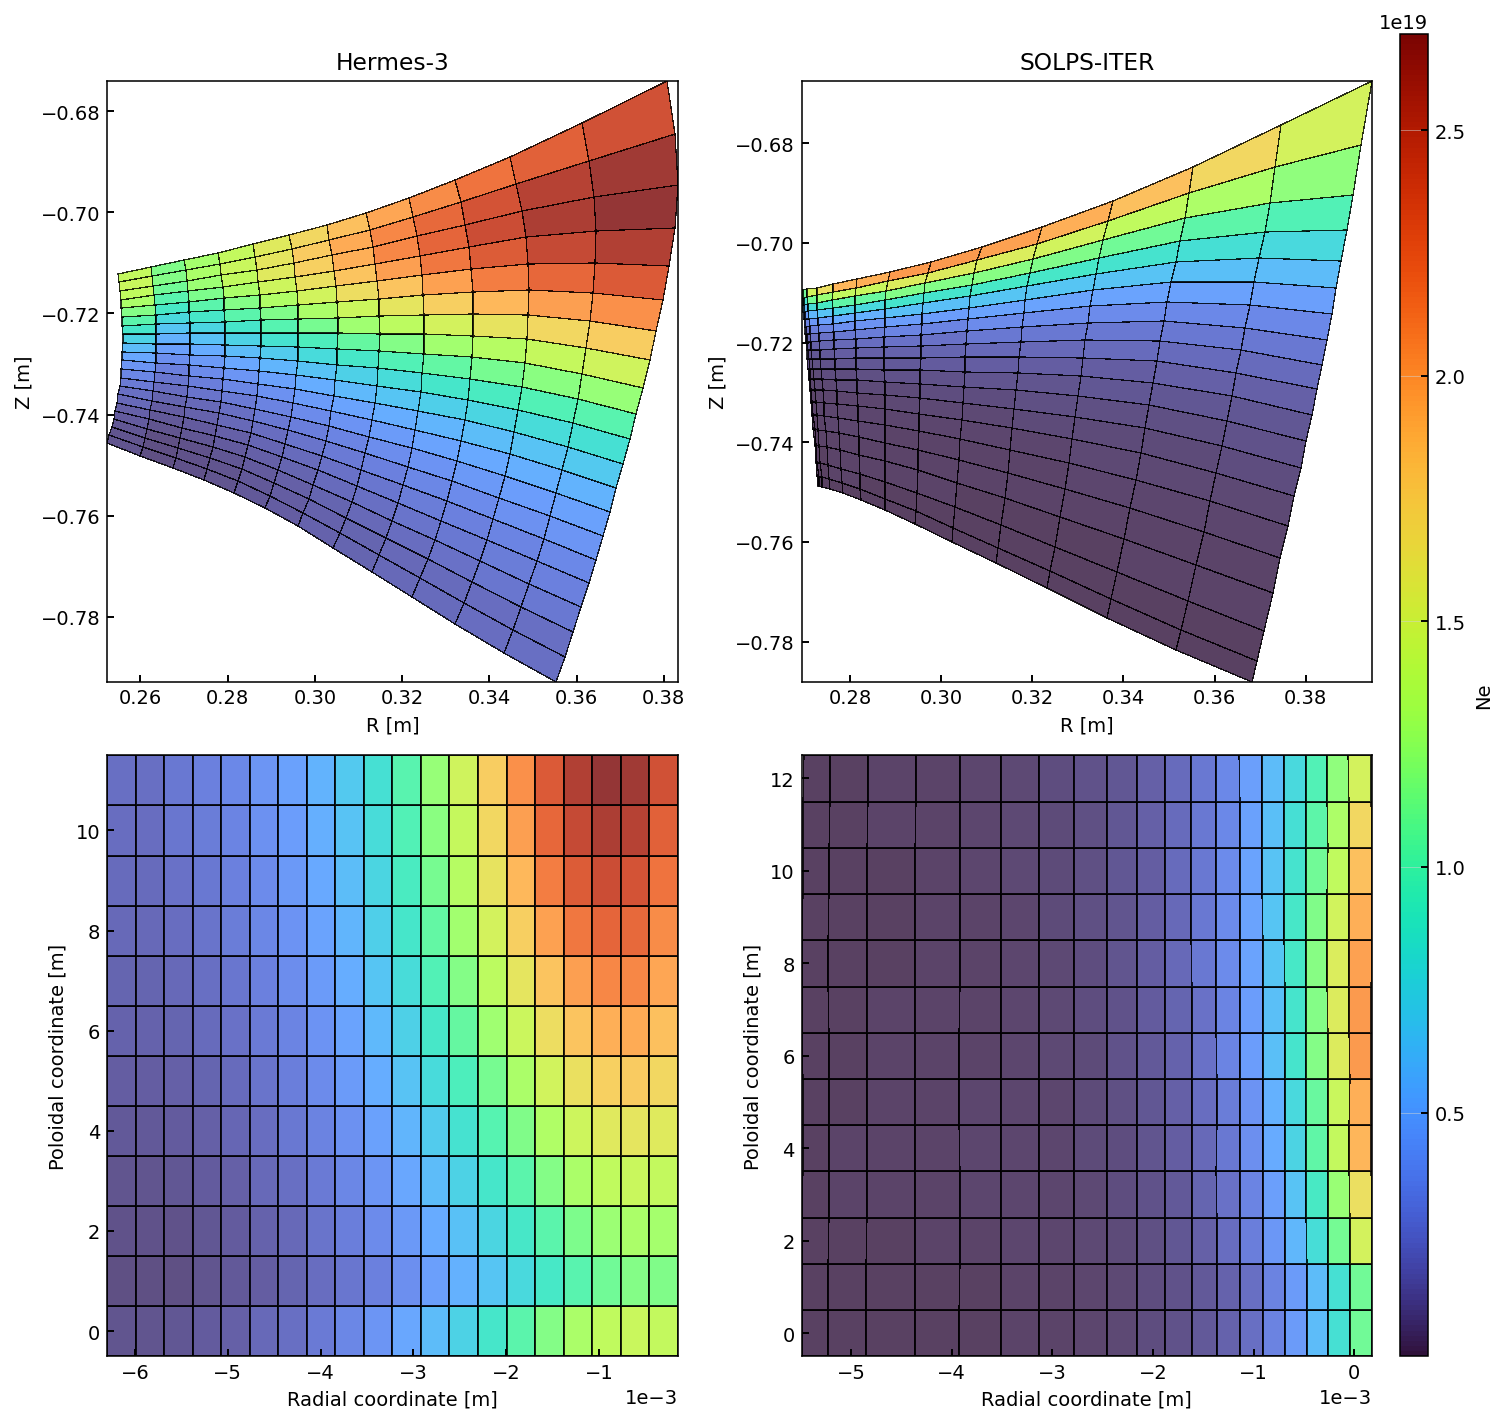

In [31]:
plt.close("all")

# region = "lower_inner_PFR"
# for region in regions:
for region in ["lower_inner_PFR"]:
	color = colors[list(regions).index(region)]
	cmap = mpl.colors.ListedColormap([color])
	cmap = "turbo"
	logscale = False


	### Data prep
	## Hermes-3
	# reg = ds[ds.regions[region].get_slices()]
	# pol_h = np.cumsum(reg["dl"], axis = 1)
	# rad_h = np.cumsum(reg["dr"], axis = 0)
 
	# pol_h = np.cumsum(ds["dl"], axis = 1)[ds.regions[region].get_slices()]
	# rad_h = np.cumsum(ds["dr"], axis = 0)[ds.regions[region].get_slices()]
 
	# Prepare radial and poloidal
	rad_h = ds["psi_poloidal"].values
	pol_h = ds["theta_idx"].values
	pol_h = np.expand_dims(pol_h, axis = 0)
	pol_h = np.expand_dims(pol_h, axis = 2)
	pol_h = np.repeat(pol_h, rad_h.shape[0], axis = 0)

	rad_h = rad_h.squeeze()
	pol_h = pol_h.squeeze()
 
	# Select region
	slices = ds.regions[region].get_slices()
	rad_h = rad_h[slices["x"], slices["theta"]]
	pol_h = pol_h[slices["x"], slices["theta"]]
	R_h = ds["R"].values[slices["x"], slices["theta"]]
	Z_h = ds["Z"].values[slices["x"], slices["theta"]]
 
	# Select data (colour)
	c_h = ds["Ne"][slices]

	## SOLPS-ITER
	rad_s = spsi   # Scaled against Hermes-3 earlier
	pol_s = np.array(range(rad_s.shape[0]))
	pol_s = np.expand_dims(pol_s, axis = 1)
	pol_s = np.repeat(pol_s, rad_s.shape[1], axis = 1)
 
	rad_s = rad_s[region_sel[region]]
	pol_s = pol_s[region_sel[region]]

	R_s = spc.g["R"][region_sel[region]]
	Z_s = spc.g["Z"][region_sel[region]]
	c_s = spc.bal["ne"][:][region_sel[region]]

	## Plots
	fig, axes = plt.subplots(2,2, figsize = (10,10))

	vmin = np.min([np.min(c_h), np.min(c_s)])
	vmax = np.max([np.max(c_h), np.max(c_s)])
	norm = create_norm(logscale, None, vmin, vmax)
	
	stylekwargs = dict(cmap = cmap,
				rasterized = True,
				edgecolor = "k",
				linewidth = 0.1,
				alpha = 0.8,
				shading = "nearest",
				norm = norm
				)

	# Hermes-3
	axes[1,0].pcolormesh(rad_h, pol_h, c_h, **stylekwargs)
	axes[0,0].pcolormesh(R_h, Z_h, c_h, **stylekwargs)

	# SOLPS-ITER
	axes[1,1].pcolormesh(rad_s, pol_s, c_s, **stylekwargs)
	axes[0,1].pcolormesh(R_s, Z_s, c_s, **stylekwargs)

	## Formatting
	for ax in axes.flatten():
		ax.grid(False)
		
	for ax in axes[0,:].flatten():
		ax.set_xlabel("R [m]")
		ax.set_ylabel("Z [m]")
	
	for ax in axes[1,:].flatten():
		ax.set_xlabel("Radial coordinate [m]")
		ax.set_ylabel("Poloidal coordinate [m]")
	
	axes[0,0].set_title("Hermes-3")
	axes[0,1].set_title("SOLPS-ITER")

	sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
	fig.tight_layout()
	cax = fig.add_axes([
		axes[0,1].get_position().x1+0.02,
		axes[1,1].get_position().y0,
		0.02,
		axes[1,1].get_position().height * 2.2
	])

	cbar = plt.colorbar(mappable = sm, cax=cax, label = "Ne") # Similar to fig.colorbar(im, cax = cax)


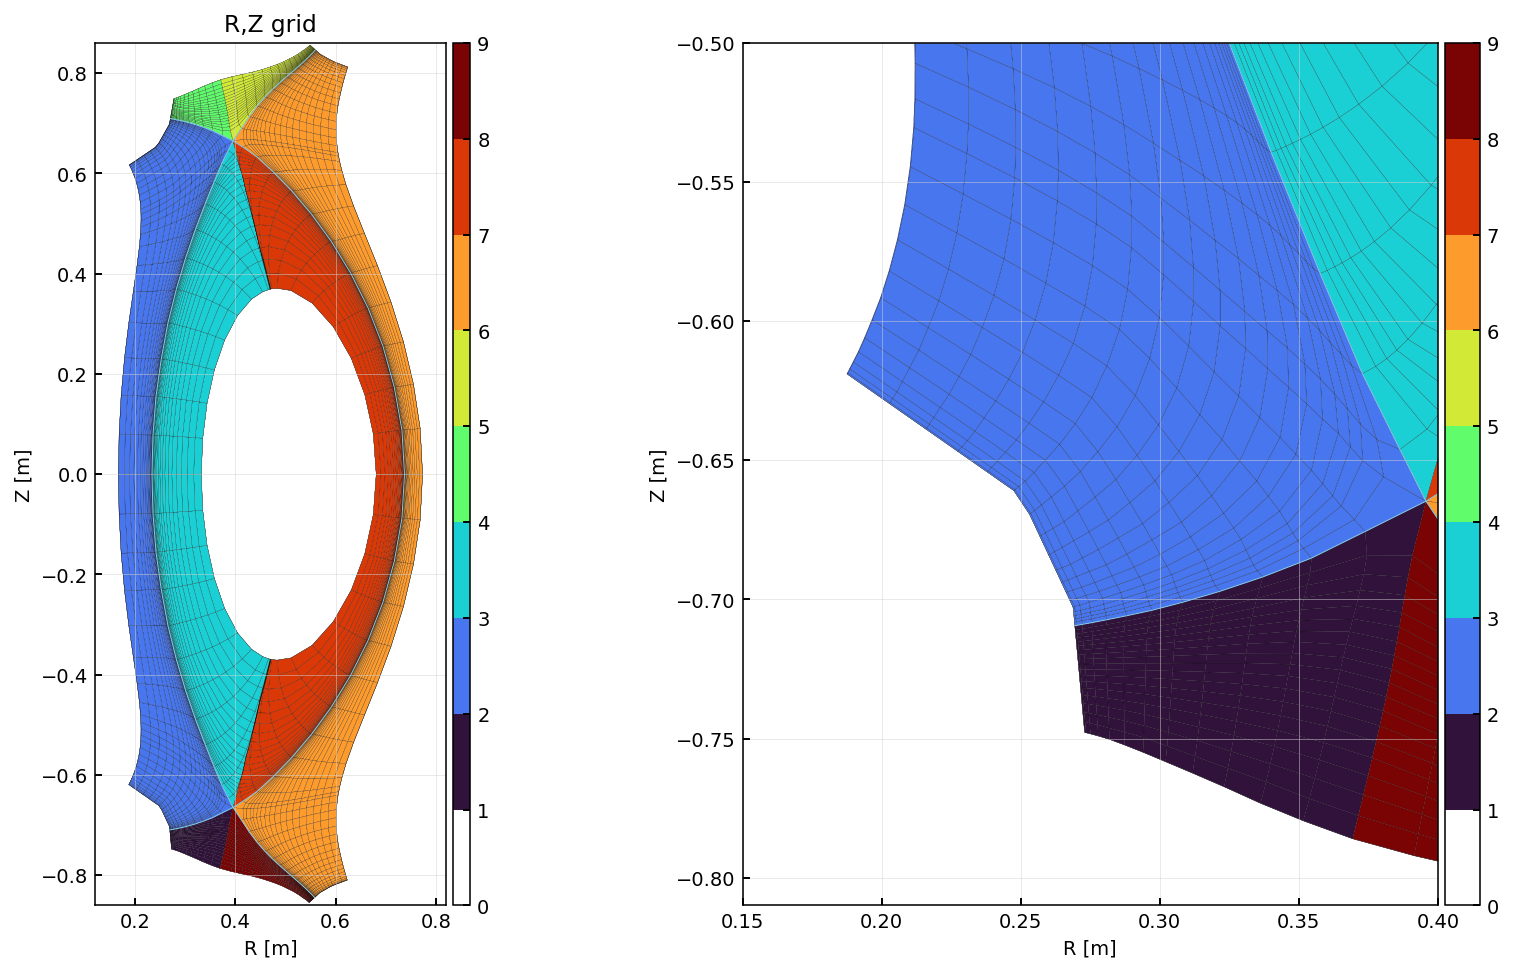

In [ ]:

### Original regions
f = 1  # Offset factor. Idk why it's required, and it seems to change between 1 and 2
region_sel = {}
region_sel["lower_inner_PFR"] = (slice(None, leftcut[0]+1), slice(None, sep+1))
region_sel["lower_inner_SOL"] = (slice(None, leftcut[0]+1), slice(sep+1, None))
region_sel["inner_core"] = (slice(leftcut[0]+1, leftcut[1]+1), slice(None, sep+1))
region_sel["inner_SOL"] = (slice(leftcut[0]+1, leftcut[1]+1), slice(sep+1, None))
region_sel["upper_inner_PFR"] = (slice(leftcut[1]+1, upper_break), slice(None, sep+1))
region_sel["upper_inner_SOL"] = (slice(leftcut[1]+1, upper_break), slice(sep+1, None))
region_sel["upper_outer_PFR"] = (slice(upper_break, rightcut[1]+1), slice(None, sep+1))
region_sel["upper_outer_SOL"] = (slice(upper_break, rightcut[1]+1), slice(sep+1, None))
region_sel["outer_core"] = (slice(rightcut[1]+1, rightcut[0]+1), slice(None, sep+1))
region_sel["outer_SOL"] = (slice(rightcut[1]+1, rightcut[0]+1), slice(sep+1, None))
region_sel["lower_outer_PFR"] = (slice(rightcut[0]+1, None), slice(None, sep+1))
region_sel["lower_outer_SOL"] = (slice(rightcut[0]+1, None), slice(sep+1, None))


data = spc.bal["ne"][:]
data = np.zeros_like(data)


### Grouped regions
group_sel = {}
group_sel["lower_inner_PFR"] = region_sel["lower_inner_PFR"]
group_sel["inner_full_SOL"] = (slice(None, upper_break), slice(sep+1, None))
group_sel["inner_core"] = region_sel["inner_core"]
group_sel["upper_inner_PFR"] = region_sel["upper_inner_PFR"]
group_sel["upper_outer_PFR"] = region_sel["upper_outer_PFR"]
group_sel["outer_full_SOL"] = (slice(upper_break, None), slice(sep+1, None))
group_sel["outer_core"] = region_sel["outer_core"]
group_sel["lower_outer_PFR"] = region_sel["lower_outer_PFR"]
		
##  Region select
regions = group_sel

##  Mark the regions with different colors
for i, key in enumerate(regions):
	i += 1		
	data[regions[key]] = i

colors = mpl.colormaps["turbo"](np.linspace(0, 1, len(regions.keys())))

fig, axes = plt.subplots(1,2, figsize = (14,8), dpi = 140, width_ratios=(0.5,1))
for i, ax in enumerate(axes):
	spc.plot_2d("", ax = axes[i], data = data, cmap = mpl.colors.ListedColormap(["white"] + list(colors)),
		antialias = True, 
		cbar = True,
		vmin = 0, vmax = len(regions.keys())+1,
		linecolor = "black", linewidth = 0.1,
		separatrix_kwargs = dict(lw = 0.5, c = "skyblue"))

axes[0].set_xlim(0.12, 0.82)
axes[0].set_ylim(-0.86, 0.86)
axes[0].set_title("R,Z grid")
		
def zoomView(ax, region):
	lims = dict(
		lower_inner = dict(
				xlim = (0.15, 0.4),
				ylim = (-0.81, -0.5)
		),
		upper = dict(
				xlim = (0.15, 0.7),
				ylim = (0.5, 0.9)
		)
	)
	
	if region in lims.keys():
		ax.set_xlim(lims[region]["xlim"])
		ax.set_ylim(lims[region]["ylim"])
	else:
		raise Exception(f"Region {region} not found")
				
		
zoomView(axes[1], "lower_inner")
		
# spc.plot_selection(sel)